In [ ]:
!pip install --upgrade tensorflow==1.15

Requirement already up-to-date: tensorflow==1.15 in /usr/local/lib/python3.7/dist-packages (1.15.0)


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

# LOAD DATASET

In [ ]:
data = pd.read_csv('clustering.csv')
data.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,4,1,p,e,3,2,2,7,7,p,2,1,4,2,s,u
1,e,x,s,9,1,a,e,2,2,2,7,7,p,2,1,4,3,n,g
2,e,b,s,8,1,l,e,2,2,2,7,7,p,2,1,4,3,n,m
3,p,x,y,8,1,p,e,3,2,2,7,7,p,2,1,4,2,s,u
4,e,x,s,3,0,n,t,3,2,2,7,7,p,2,1,0,3,a,g


In [ ]:
data.columns

Index(['class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
       'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
       'stalk-surface-below-ring', 'stalk-color-above-ring',
       'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number',
       'ring-type', 'spore-print-color', 'population', 'habitat'],
      dtype='object')

# FEATURE SELECTION

In [ ]:
data['cap-shape'] = data['cap-shape'].replace(['b','c', 'x', 'f', 'k', 's'], [1, 2, 3, 4, 5, 6])
data['stalk-shape'] = data['stalk-shape'].replace(['e', 't'], [1, 2])
data['veil-type'] = data['veil-type'].replace(['p', 'u'], [1, 2])

data.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,3,s,4,1,p,1,3,2,2,7,7,1,2,1,4,2,s,u
1,e,3,s,9,1,a,1,2,2,2,7,7,1,2,1,4,3,n,g
2,e,1,s,8,1,l,1,2,2,2,7,7,1,2,1,4,3,n,m
3,p,3,y,8,1,p,1,3,2,2,7,7,1,2,1,4,2,s,u
4,e,3,s,3,0,n,2,3,2,2,7,7,1,2,1,0,3,a,g


In [ ]:
X = data[['bruises', 'cap-shape', 'stalk-shape', 'veil-type', 'spore-print-color']]
X.head()

,bruises,cap-shape,stalk-shape,veil-type,spore-print-color
0,1,3,1,1,2
1,1,3,1,1,3
2,1,1,1,1,3
3,1,3,1,1,2
4,0,3,2,1,3


# Dataset Normalization

In [ ]:
def calculate_mean(X):
  return tf.reduce_mean(X, axis=0)

def calculate_std(X):
  return tf.math.reduce_std(X, axis=0)

def normalized_dataset(X, mean, std):
  return (X - mean) / (std + 1e-8)

In [ ]:
X = tf.convert_to_tensor(X.values, dtype=tf.float32)
mean = calculate_mean(X)
std = calculate_std(X)
X = normalized_dataset(X,mean, std) # Normalized

# Feature Extraction / PCA

In [ ]:
with tf.Session() as sess:
  X = sess.run(X)
  pca = PCA(n_components=3) # 3 Components
  pca = pca.fit(X)
  X = pca.transform(X)

# SOM Class

In [ ]:
class SOM:
    def __init__(self, width, height, n_features, learning_rate):
        self.width = width
        self.height = height
        self.n_features = n_features
        self.learning_rate = learning_rate

        # Number of cluster equal height
        self.cluster = [[] for i in range(height)]
        self.weight = tf.Variable(
            tf.random_normal([self.width * self.height, n_features]),
            tf.float32
        )
        self.input = tf.compat.v1.placeholder(
            tf.float32, [n_features], 'input-placeholder'
        )

        self.location = []
        for y in range(height):
            for x in range(width):
                self.location.append(tf.cast([y,x], tf.float32)
                )

        self.bmu = self.get_bmu()
        self.update = self.update_neighbors()
    
    def get_bmu(self):
        distance = tf.sqrt(
            tf.reduce_mean(
                (self.input - self.weight)**2,
                axis= 1
            )
        )
        bmu_index = tf.argmin(distance)
        bmu_location = tf.cast([
            tf.div(bmu_index, self.width),
            tf.mod(bmu_index, self.width)
        ], tf.float32)
        return bmu_location
    
    def update_neighbors(self):
        distance = tf.sqrt(
            tf.reduce_mean(
                (self.bmu - self.location)**2,
                axis= 1
            )
        )
        sigma = tf.cast(tf.maximum(self.width, self.height)/2, tf.float32)
        neighbor_strength = tf.exp(
            -(distance ** 2)/(2 * sigma ** 2)
        )
        rate = neighbor_strength * self.learning_rate

        stacked_rate = []
        for i in range(self.width * self.height):
            stacked_rate.append(
                tf.tile(
                    [rate[i]],
                    [self.n_features]
                )
            )
        delta = (stacked_rate*(self.input - self.weight))
        new_weight = self.weight + delta 
        return tf.assign(self.weight, new_weight)
    
    def train(self, dataset, num_epoch):
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())

            for epoch in range(num_epoch):
                if epoch % 100 == 0:
                  print(f'Epoch {epoch}: ', end='')
                for data in dataset:
                    dict = {
                        self.input : data
                    }
                    sess.run(self.update, feed_dict=dict)
                if epoch % 100 == 0:
                  print('Done')

            location = sess.run(self.location)
            weight = sess.run(self.weight)
            
            for i, loc in enumerate(location):
                self.cluster[int(loc[0])].append(weight[i])


# Training

In [ ]:
n_features = 3
learning_rate = 0.1
epochs = 2500

som = SOM(20, 20, n_features, learning_rate)
som.train(X, epochs)

Epoch 0: Done
Epoch 100: Done
Epoch 200: Done
Epoch 300: Done
Epoch 400: Done
Epoch 500: Done
Epoch 600: Done
Epoch 700: Done
Epoch 800: Done
Epoch 900: Done
Epoch 1000: Done
Epoch 1100: Done
Epoch 1200: Done
Epoch 1300: Done
Epoch 1400: Done
Epoch 1500: Done
Epoch 1600: Done
Epoch 1700: Done
Epoch 1800: Done
Epoch 1900: Done
Epoch 2000: Done
Epoch 2100: Done
Epoch 2200: Done
Epoch 2300: Done
Epoch 2400: Done


# Visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


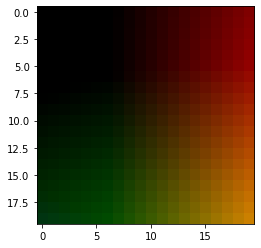

In [ ]:
plt.imshow(som.cluster)
plt.show()